# Landscape clustering: topographic, climatic, soil and land use

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import time

In [2]:
file_path = Path('/Users/wmk934/data/perceptual_models/data/zonal_stats/')
dat_file_name = 'zonal_stats.csv'
shp_file_name = 'merit_hydro_basins_MODIS_IGBP_counts.shp'

In [3]:
dat = pd.read_csv(file_path/dat_file_name)

In [4]:
shp = gpd.read_file(file_path/shp_file_name)

In [5]:
# Merge the whole thing so we can look at geographical locations
dat = dat.set_index('COMID')
shp = shp.set_index('COMID')
assert (dat.index == shp.index).all() # pops an error if index (COMID) order is not the same in both dataframes
dat['geometry'] = shp['geometry']
dat = gpd.GeoDataFrame(dat)

### Prepare dataframe for clustering

In [6]:
dat.columns

Index(['unitarea', 'elev_mean', 'elev_stdev', 'elev_min', 'elev_max',
       'slope_mean', 'slope_stdev', 'slope_min', 'slope_max', 'im_mean',
       'im_stdev', 'imr_mean', 'imr_stdev', 'fs_mean', 'fs_stdev', 'lg_water',
       'lg_non-cro', 'lg_irrigat', 'lg_rainfed', 'igbp_1', 'igbp_2', 'igbp_3',
       'igbp_4', 'igbp_5', 'igbp_6', 'igbp_7', 'igbp_8', 'igbp_9', 'igbp_10',
       'igbp_11', 'igbp_12', 'igbp_13', 'igbp_14', 'igbp_15', 'igbp_16',
       'igbp_17', 'igbp_255', 'depth_mean', 'depth_stde', 'depth_min',
       'depth_max', 'pfaf', 'area_km2', 'igbp_mode', 'lgrip_mode', 'geometry'],
      dtype='object')

In [7]:
cluster_data = dat[['elev_mean','slope_mean','im_mean','imr_mean','fs_mean','depth_mean',
                    'lg_water','lg_non-cro', 'lg_irrigat', 'lg_rainfed', 
                    'igbp_1', 'igbp_2', 'igbp_3','igbp_4', 'igbp_5', 'igbp_6', 'igbp_7', 'igbp_8','igbp_9',
                    'igbp_10','igbp_11', 'igbp_12', 'igbp_13', 'igbp_14', 'igbp_15', 'igbp_16','igbp_17',
                    'geometry']]

In [8]:
mask = cluster_data.isna()
area = dat[dat.isna().any(axis=1)]['area_km2'].sum()
apct = area / dat['area_km2'].sum()
cluster_data = cluster_data.dropna()
print(f'Dropped {len(dat)-len(cluster_data)} rows, with a total area of {area:0.2} km^2 ({apct:0.2}% of total land mass).')

Dropped 57332 rows, with a total area of 5.8e+05 km^2 (0.027% of total land mass).


Inspection shows that these are mostly very small islands off the coasts. There's just a lot of them but in terms of land mass they are insignificant.

In [9]:
cluster_temp = cluster_data.drop(columns=['geometry']) # Cluster without the geometries, but we need these later so we keep them in the GDF

In [10]:
scaler = preprocessing.StandardScaler().fit(cluster_temp) 

In [11]:
cluster_input = scaler.transform(cluster_temp)

### Cluster

In [85]:
# Create the output folder for the clustering results
cluster_path = Path('/Users/wmk934/data/perceptual_models/data/clustering')
cluster_path.mkdir(parents=True,exist_ok=True)

In [15]:
# General settings
n_reruns = 10
n_clusters_range = range(2,50)

In [100]:
# Loop over the n_clusters
inertia = []
for n_clusters in n_clusters_range:
    start = time.time()
    kmeans =  KMeans(n_clusters = n_clusters, init='k-means++', n_init = n_reruns)
    kmeans.fit(cluster_input)
    cluster_data[f'cluster_{n_clusters}'] = kmeans.labels_
    inertia.append(kmeans.inertia_)
    end = time.time()
    print(f'Clustering {n_clusters:02} clusters with {n_reruns} re-runs took {end-start:0.4} s. Inertia = {kmeans.inertia_:0.8}')
cluster_file = f'clustering_results_clusters_2_to_50.shp'
cluster_data.to_file(cluster_path/cluster_file)

Clustering 02 clusters with 10 re-runs took 3.676 s. Inertia = 1.2152824e+07
Clustering 03 clusters with 10 re-runs took 3.929 s. Inertia = 1.1432078e+07
Clustering 04 clusters with 10 re-runs took 4.263 s. Inertia = 1.0883845e+07
Clustering 05 clusters with 10 re-runs took 5.024 s. Inertia = 1.0472462e+07
Clustering 06 clusters with 10 re-runs took 5.493 s. Inertia = 1.0077888e+07
Clustering 07 clusters with 10 re-runs took 6.263 s. Inertia = 9733225.2
Clustering 08 clusters with 10 re-runs took 6.032 s. Inertia = 9432080.7
Clustering 09 clusters with 10 re-runs took 6.732 s. Inertia = 9085631.6
Clustering 10 clusters with 10 re-runs took 6.325 s. Inertia = 8818842.2
Clustering 11 clusters with 10 re-runs took 7.04 s. Inertia = 8532133.8
Clustering 12 clusters with 10 re-runs took 7.362 s. Inertia = 8201076.4
Clustering 13 clusters with 10 re-runs took 7.106 s. Inertia = 7874627.0
Clustering 14 clusters with 10 re-runs took 6.565 s. Inertia = 7660386.3
Clustering 15 clusters with 10 r

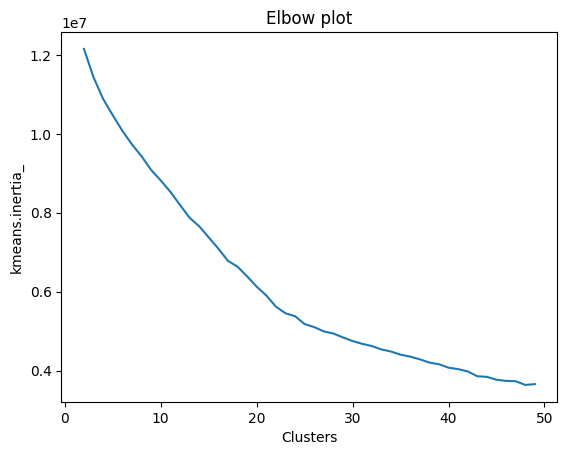

In [126]:
# Elbow plot
plt.plot(n_clusters,inertia)
plt.xlabel('Clusters')
plt.ylabel('kmeans.inertia_')
plt.title('Elbow plot');

## Silhouette plots
Clearly the elbow plot doesn't tell us much: there is no clear elbow. Possibly better (but slwoer) are silhouette plots. These let us compare within-cluster and between-cluster differences.

In [12]:
def plot_silhouette(cluster_input, n_clusters, cluster_labels, sample_silhouette_values, silhouette_avg, inertia):
    
    '''Creates a silhouette plot'''

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 6)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (num_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(cluster_input) + (n_clusters + 1) * 10])
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
    
        ith_cluster_silhouette_values.sort()
    
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
    
        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
    
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title(f"Silhouette plot for {n_clusters} clusters. Inertia = {inertia:.0f}")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]);
    
    return # nothing

In [13]:
# Save location
img_path = Path('/Users/wmk934/data/perceptual_models/img/cluster_silhouettes')
img_path.mkdir(parents=True, exist_ok=True)

In [18]:
# Loop over the n_clusters
for n_clusters in n_clusters_range:
    start = time.time()
    
    kmeans =  KMeans(n_clusters = n_clusters, init='k-means++', n_init = n_reruns)
    kmeans.fit(cluster_input)
    
    silhouette_avg = silhouette_score(cluster_input, kmeans.labels_)
    sample_silhouette_values = silhouette_samples(cluster_input, kmeans.labels_)
    plot_silhouette(cluster_input, n_clusters, kmeans.labels_, sample_silhouette_values, silhouette_avg, kmeans.inertia_)
    plt.savefig(img_path / f'clustering_silhouettes_{n_clusters:02}.png', dpi=300, bbox_inches='tight')
    plt.close()

    end = time.time()
    print(f'Clustering {n_clusters:02} clusters with {n_reruns} re-runs took {end-start:0.4} s. Inertia = {kmeans.inertia_:0.8}')

Clustering 02 clusters with 10 re-runs took 3.415e+03 s. Inertia = 1.2152821e+07
Clustering 03 clusters with 10 re-runs took 3.266e+03 s. Inertia = 1.1432077e+07
Clustering 04 clusters with 10 re-runs took 3.118e+03 s. Inertia = 1.0883847e+07
Clustering 05 clusters with 10 re-runs took 3.117e+03 s. Inertia = 1.0472461e+07
Clustering 06 clusters with 10 re-runs took 3.106e+03 s. Inertia = 1.0099364e+07
Clustering 07 clusters with 10 re-runs took 3.038e+03 s. Inertia = 9750535.8
Clustering 08 clusters with 10 re-runs took 3.083e+03 s. Inertia = 9413470.9
Clustering 09 clusters with 10 re-runs took 2.948e+03 s. Inertia = 9125869.8
Clustering 10 clusters with 10 re-runs took 2.989e+03 s. Inertia = 8809073.1
Clustering 11 clusters with 10 re-runs took 2.946e+03 s. Inertia = 8510917.9
Clustering 12 clusters with 10 re-runs took 2.959e+03 s. Inertia = 8226746.9
Clustering 13 clusters with 10 re-runs took 2.91e+03 s. Inertia = 7872885.2
Clustering 14 clusters with 10 re-runs took 2.958e+03 s. 

### Cluster by landform